# QST CGAN with thermal noise in the channel (convolution)

In [1]:
import numpy as np

from qutip import Qobj, fidelity
from qutip.wigner import qfunc
from qutip.states import thermal_dm
from qutip import coherent_dm
from qutip.visualization import plot_wigner_fock_distribution



import tensorflow_addons as tfa
import tensorflow as tf


from qst_nn.ops import (cat, binomial, num, gkp, GaussianConv, husimi_ops, convert_to_real_ops, dm_to_tf, batched_expect)
from qst_cgan.gan import DensityMatrix, Expectation, Discriminator, generator_loss, discriminator_loss
from qst_cgan.ops import convert_to_complex_ops, tf_fidelity


from tqdm.auto import tqdm

from dataclasses import dataclass


import matplotlib.pyplot as plt
tf.keras.backend.set_floatx('float64') # Set float64 as the default

In [2]:
# https://scipy-cookbook.readthedocs.io/items/Matplotlib_LaTeX_Examples.html
fig_width_pt = 246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
params = {
          'axes.labelsize': 9,
          'font.size': 9,
          'legend.fontsize': 9,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': True,
          'figure.figsize': fig_size,
          'axes.labelpad':1,
          'legend.handlelength':0.8,
          'axes.titlesize': 9,
    "text.usetex"        : False
          }
plt.rcParams.update(params)

# mpl.use('pdf')

# We create the state and the data using QuTiP

In [3]:
hilbert_size = 32

# Betas can be selected in a grid or randomly in a circle
num_grid = 32
num_points = num_grid*num_grid

beta_max_x = 5
beta_max_y = 5

xvec = np.linspace(-beta_max_x, beta_max_x, num_grid)
yvec = np.linspace(-beta_max_y, beta_max_y, num_grid)

X, Y = np.meshgrid(xvec, yvec)
betas = (X + 1j*Y).ravel()

# Measurement ops are simple projectors $\frac{1}{\pi}|\beta \rangle \langle \beta|$

In [4]:
m_ops = [(1/np.pi)*coherent_dm(hilbert_size, beta) for beta in betas]
ops_numpy = [op.data.toarray() for op in m_ops] # convert the QuTiP Qobj to numpy arrays
ops_tf = tf.convert_to_tensor([ops_numpy]) # convert the numpy arrays to complex TensorFlow tensors

A = convert_to_real_ops(ops_tf) # convert the complex-valued numpy matrices to real-valued TensorFlow tensors
print(A.shape, A.dtype)

(1, 32, 32, 2048) <dtype: 'float64'>


2021-10-01 14:22:11.863104: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Convolution noise

The presence of thermal photons in the amplification channel lead to the data being
corrupted as a convolution over the Q function data (see [https://arxiv.org/abs/1206.3405](https://arxiv.org/abs/1206.3405))

The kernel for this convolution is a Gaussian determined by the average photon number in the thermal state. We corrupt our data assuming a thermal state with mean photon number 5. 

In [5]:
# define normalized 2D gaussian
def gaus2d(x=0, y=0, n0=1):
    return 1. / (np.pi * n0) * np.exp(-((x**2 + y**2.0)/n0))

nth = 5
X, Y = np.meshgrid(xvec, yvec) # get 2D variables instead of 1D
gauss_kernel = gaus2d(X, Y, n0=nth)

# State to reconstruct

Let us now create a state on which we will run QST

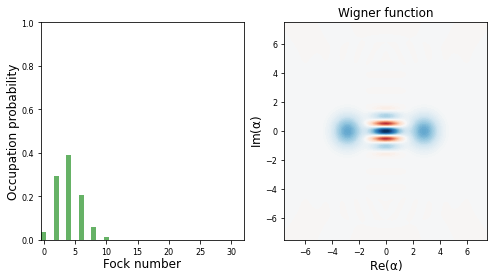

In [6]:
rho, _ = cat(hilbert_size, 2, 0, 0)
plot_wigner_fock_distribution(rho)
plt.show()

In [7]:

rho_tf = dm_to_tf([rho])
data = batched_expect(ops_tf, rho_tf)

# Q function plots using QuTiP and a custom TensorFlow expectation function

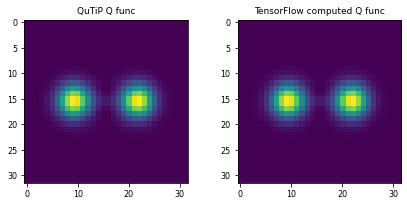

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].imshow(qfunc(rho, xvec, yvec, g=2))
ax[1].imshow(data.numpy().reshape(num_grid, num_grid))
ax[0].set_title("QuTiP Q func")
ax[1].set_title("TensorFlow computed Q func")
plt.show()

(<Figure size 576x288 with 2 Axes>,
 array([<AxesSubplot:xlabel='Fock number', ylabel='Occupation probability'>,
        <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

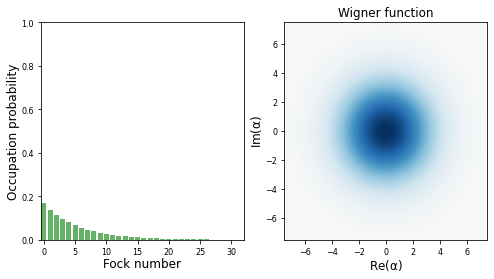

In [9]:
# The thermal state distribution
plot_wigner_fock_distribution(thermal_dm(hilbert_size, nth))

# Apply the convolution and show the simulated data that we can obtain experimentally

In [56]:
x = tf.reshape(tf.cast(data, tf.float64), (1, num_grid, num_grid, 1))

conved = GaussianConv(gauss_kernel)(x)

kernel = gauss_kernel/tf.reduce_max(gauss_kernel)
diff = conved.numpy().reshape(num_grid, num_grid)/tf.reduce_max(conved) - kernel.numpy().reshape(num_grid, num_grid)
diff = tf.convert_to_tensor(diff)


# Collect all the data in an array for plotting
matrices = [gauss_kernel.reshape((num_grid, num_grid)), x.numpy().reshape((num_grid, num_grid)), 
            conved.numpy().reshape((num_grid, num_grid)), diff.numpy().reshape((num_grid, num_grid))]

/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_65933/3526584348.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[i].pcolor(xvec, yvec,
/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_65933/3526584348.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(["", "", ""])
/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_65933/3526584348.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(["", "", ""], fontsize=6)
/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_65933/3526584348.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axe

Text(0, 0.5, 'Im$(\\beta)$')

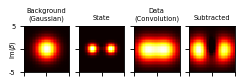

In [57]:
fig, ax = plt.subplots(1, 4, figsize=(fig_width, 0.35*2.5*fig_height), dpi=80, facecolor="white",
                             sharey=False, sharex=True)

axes = [ax[0], ax[1], ax[2], ax[3]]

aspect = 'equal'

for i in range(4):
    im = axes[i].pcolor(xvec, yvec,
                   matrices[i]/np.max(matrices[i]), cmap="hot", vmin=0, vmax=1)
    axes[i].set_aspect("equal")
    axes[i].set_xticklabels(["", "", ""])
    axes[i].set_yticklabels(["", "", ""], fontsize=6)
    # axes[i].set_xlabel(r"$Re(\beta)$", fontsize=6)    
axes[0].set_yticklabels(["-5", "", "5"], fontsize=6)

labels = ["Background\n(Gaussian)", "State", "Data\n(Convolution)", "Subtracted"]

for i in range(len(labels)):
    axes[i].set_title(labels[i], fontsize=6)

# plt.subplots_adjust(wspace=-.4)
# cbar = fig.colorbar(im, ax=axes, pad=0.026, fraction = 0.046)
# cbar.ax.set_yticklabels(["0", "0.5", "1"])

axes[0].set_ylabel(r"Im$(\beta)$", labelpad=-8, fontsize=6)

######################################################################################################

# QST CGAN with a Gaussian convolution layer

In [58]:
def GeneratorConvQST(hilbert_size, num_points, noise=0.02, kernel=None):
    """
    A tensorflow generative model which can be called as 
                  >> generator([A, x])
    where A is the set of all measurement operators
    transformed into the shape (batch_size, hilbert_size, hilbert_size, num_points*2)
    This can be done using the function `convert_to_real_ops` which
    takes a set of complex operators shaped as (batch_size, num_points, hilbert_size, hilbert_size)
    and converts it to this format which is easier to run convolution operations on.

    x is the measurement statistics (frequencies) represented by a vector of shape
    [batch_size, num_points] where we consider num_points different operators and their
    expectation values.

    Args:
        hilbert_size (int): Hilbert size of the output matrix
                            This needs to be 32 now. We can adjust 
                            the network architecture to allow it to
                            automatically change its outputs according
                            to the hilbert size in future
        num_points (int): Number of different measurement operators
    
    Returns:
        generator: A TensorFlow model callable as
        >> generator([A, x])
    
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    
    n = int(hilbert_size/2)
    
    ops = tf.keras.layers.Input(shape=[hilbert_size, hilbert_size, num_points*2],
                                name='operators')
    inputs = tf.keras.Input(shape=(num_points), name = "inputs")
    

    x = tf.keras.layers.Dense(16*16*2, use_bias=False,
                              kernel_initializer = tf.random_normal_initializer(0., 0.02),
                             )(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Reshape((16, 16, 2))(x)

    x = tf.keras.layers.Conv2DTranspose(64, 4, use_bias=False,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer=initializer)(x)
    x = tfa.layers.InstanceNormalization(axis=3)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(64, 4, use_bias=False,
                                        strides=1,
                                        padding='same',
                                        kernel_initializer=initializer)(x)
    x = tfa.layers.InstanceNormalization(axis=3)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(32, 4, use_bias=False,
                                        strides=1,
                                        padding='same',
                                        kernel_initializer=initializer)(x)
    # x = tfa.layers.InstanceNormalization(axis=3)(x)
    # x = tf.keras.layers.LeakyReLU()(x)
    # y = tf.keras.layers.Conv2D(8, 5, padding='same')(ops)
    # out = x
    # x = tf.keras.layers.concatenate([x, y])
    x = tf.keras.layers.Conv2DTranspose(2, 4, use_bias=False,
                                    strides=1,
                                    padding='same',
                                    kernel_initializer=initializer)(x)
    x = DensityMatrix()(x)
    complex_ops = convert_to_complex_ops(ops)
    # prefactor = (0.25*g**2/np.pi)
    prefactor = 1.
    x = Expectation()(complex_ops, x, prefactor)
    
    x = tf.keras.layers.Reshape((32, 32, 1))(x)

    x = GaussianConv(kernel, trainable=False)(x)
    # x = x/tf.reduce_max(x)

    x = tf.keras.layers.Reshape((num_points,))(x)
    
    # y = kernel/tf.reduce_max(kernel)
    # y = tf.reshape(y, (1, num_points))
    # x = x - y

    return tf.keras.Model(inputs=[ops, inputs], outputs=x)

In [59]:
tf.keras.backend.clear_session()
generator = GeneratorConvQST(hilbert_size, num_points, kernel=gauss_kernel)
discriminator = Discriminator(hilbert_size, num_points)


In [60]:
density_layer_idx = None

for i, layer in enumerate(generator.layers):
    if "density_matrix" in layer._name:
        density_layer_idx = i
        break

print(density_layer_idx)
model_dm = tf.keras.Model(inputs=generator.input, outputs=generator.layers[density_layer_idx].output)

@dataclass
class LossHistory:
    """Class for keeping track of loss"""
    generator: list
    discriminator: list
    l1: list

loss = LossHistory([], [], [])
fidelities = []


initial_learning_rate = 0.0002

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate,
                                                             decay_steps=10000,
                                                             decay_rate=.96,
                                                             staircase=False)

lam = 10.

generator_optimizer = tf.keras.optimizers.Adam(lr_schedule, 0.5, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr_schedule, 0.5, 0.5)

17


In [61]:
def train_step(A, x):
    """Takes one step of training for the full A matrix representing the
    measurement operators and data x.

    Note that the `generator`, `discriminator`, `generator_optimizer` and the
    `discriminator_optimizer` has to be defined before calling this function.

    Args:
        A (tf.Tensor): A tensor of shape (m, hilbert_size, hilbert_size, n x 2)
                       where m=1 for a single reconstruction, and n represents
                       the number of measured operators. We split the complex
                       operators as real and imaginary in the last axis. The 
                       helper function `convert_to_real_ops` can be used to
                       generate the matrix A with a set of complex operators
                       given by `ops` with shape (1, n, hilbert_size, hilbert_size)
                       by calling `A = convert_to_real_ops(ops)`.

        x (tf.Tensor): A tensor of shape (m, n) with m=1 for a single
                       reconstruction and `n` representing the number of
                       measurements. 
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator([A, x], training=True)

        disc_real_output = discriminator([A, x, x], training=True)
        disc_generated_output = discriminator([A, x, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, x, lam=lam
        )
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(
        gen_total_loss, generator.trainable_variables
    )
    discriminator_gradients = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(generator_gradients, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(discriminator_gradients, discriminator.trainable_variables)
    )

    loss.generator.append(gen_gan_loss)
    loss.l1.append(gen_l1_loss)
    loss.discriminator.append(disc_loss)

max_iterations = 300
pbar = tqdm(range(max_iterations))

for i in pbar:
    train_step(A, conved.numpy().reshape(-1, num_points))
    density_matrix = model_dm([A, conved.numpy().reshape(-1, num_points)])
    rho_reconstructed = Qobj(density_matrix.numpy().reshape(rho.shape))
    f = fidelity(rho_reconstructed, rho)
    fidelities.append(f)
    pbar.set_description("Fidelity {} | Gen loss {} | L1 loss {} | Disc loss {}".format(f, loss.generator[-1], loss.l1[-1], loss.discriminator[-1]))

Fidelity 0.9198780496380545 | Gen loss 0.6897733807563782 | L1 loss 0.004995967746279077 | Disc loss 1.3856912851333618: 100%|██████████| 300/300 [00:56<00:00,  5.28it/s]


In [62]:
rho_reconstructed = Qobj(density_matrix.numpy().reshape(rho.shape))

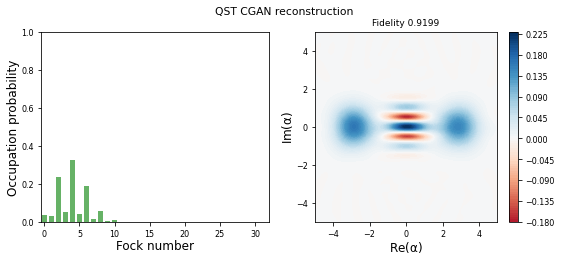

In [63]:
fig, ax = plot_wigner_fock_distribution(rho_reconstructed, alpha_max=beta_max_x, colorbar=True, figsize=(9, 3.5))
plt.title("Fidelity {:.4}".format(fidelity(rho_reconstructed, rho)))
plt.suptitle("QST CGAN reconstruction")
plt.show()

In [64]:
rho_tf_reconstructed = dm_to_tf([rho_reconstructed])
data_reconstructed = batched_expect(ops_tf, rho_tf_reconstructed)
reconstructed_x = tf.reshape(tf.cast(data_reconstructed, tf.float64), (1, num_grid, num_grid, 1))
reconstructed_conved = GaussianConv(gauss_kernel)(reconstructed_x)
diff2 = reconstructed_conved.numpy().reshape(num_grid, num_grid)/tf.reduce_max(reconstructed_conved) - kernel.numpy().reshape(num_grid, num_grid)

matrices2 = [gauss_kernel.reshape((num_grid, num_grid)), reconstructed_x.numpy().reshape((num_grid, num_grid)), 
           reconstructed_conved.numpy().reshape((num_grid, num_grid)), diff2.numpy().reshape((num_grid, num_grid))]


/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_65933/1574640556.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[i].pcolor(xvec, yvec,
/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_65933/1574640556.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(["", "", ""])
/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_65933/1574640556.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(["", "", ""], fontsize=6)
/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_65933/1574640556.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax

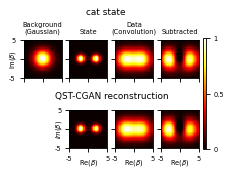

In [65]:
figpath = "figures/"

fig, ax = plt.subplots(2, 4, figsize=(fig_width, 0.35*2.5*fig_height), dpi=80, facecolor="white",
                             sharey=False, sharex=True)

axes = [ax[0, 0], ax[0, 1], ax[0, 2], ax[0, 3]]

aspect = 'equal'

for i in range(4):
    im = axes[i].pcolor(xvec, yvec,
                   matrices[i]/np.max(matrices[i]), cmap="hot", vmin=0, vmax=1)
    axes[i].set_aspect("equal")
    axes[i].set_xticklabels(["", "", ""])
    axes[i].set_yticklabels(["", "", ""], fontsize=6)
    # axes[i].set_xlabel(r"$Re(\beta)$", fontsize=6)    
axes[0].set_yticklabels(["-5", "", "5"], fontsize=6)

labels = ["Background\n(Gaussian)", "State", "Data\n(Convolution)", "Subtracted"]

for i in range(len(labels)):
    axes[i].set_title(labels[i], fontsize=6)

# plt.subplots_adjust(wspace=-.4)
# cbar = fig.colorbar(im, ax=axes, pad=0.026, fraction = 0.046)
# cbar.ax.set_yticklabels(["0", "0.5", "1"])

axes[0].set_ylabel(r"Im$(\beta)$", labelpad=-8, fontsize=6)

plt.text(x = -24.5, y=30, s="cat state", fontsize=8)

######################################################################################################

axes = [ax[1, 0], ax[1, 1], ax[1, 2], ax[1, 3]]

for i in range(1, 4):
    axes[i].pcolor(xvec, yvec,
                   matrices2[i]/np.max(matrices2[i]), cmap="hot", vmin=0, vmax=1)
    axes[i].set_aspect("equal")
    axes[i].set_xticklabels(["-5", "", "5"], fontsize=6)
    axes[i].set_yticklabels(["", "", ""])
    axes[i].set_xlabel(r"Re$(\beta)$", fontsize=6, labelpad=-4)    


labels = ["Background\n(Gaussian)", "Reconstructed\nState", r"$Convoluted\noutput$"+"\noutput", "Subtracted"]

# for i in range(1, len(labels)):
#     axes[i].set_title(labels[i], fontsize=6)

plt.subplots_adjust(hspace=0.7)
# cbar = fig.colorbar(im, ax=axes, pad=0.026, fraction = 0.046)
# cbar.ax.set_yticklabels(["0", "0.5", "1"])
plt.suptitle("QST-CGAN reconstruction", x=.45, y=.52, fontsize=8)

axes[1].set_ylabel(r"$Im(\beta)$", labelpad=-8, fontsize=6)
axes[1].set_yticklabels(["-5", "", "5"], fontsize=6)
axes[1].set_yticklabels(["-5", "", "5"])
axes[0].set_visible(False)

cbar = plt.colorbar(im, ax=ax.ravel().tolist(), aspect=40, ticks=[0, 0.5, 1], pad=0.02)
cbar.set_ticklabels(["0", "0.5", "1"])
cbar.ax.tick_params(labelsize=6) 
# plt.text(x = -44.5, y=30, s="(a)", fontsize=8)
# plt.savefig(figpath+"fig-15a-fock-reconstruction.pdf", bbox_inches="tight", pad_inches=0)